# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
from collections import deque
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="C:/Users/CuriousMode_1/deep-reinforcement-learning/p2_continuous-control/Reacher_Windows_x86_64/Reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

### 4. DDPQ Agent

In [6]:
agent = Agent(state_size=33, action_size=4, random_seed=2)

In [7]:
def ddpg(n_episodes=100000, max_t=2000, print_every=50):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations[0] 
        agent.reset()
        score = 0
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations[0]        
            rewards = env_info.rewards[0]                         
            dones = env_info.local_done[0]                       
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if dones:
                break 
        scores_deque.append(score)
        scores.append(score)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic2.pth')
            break
            
            
    return scores

scores = ddpg()

C:\Users\CuriousMode_1\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: 0.33
Episode 100	Average Score: 0.59
Episode 150	Average Score: 1.33
Episode 200	Average Score: 2.30
Episode 250	Average Score: 3.31
Episode 300	Average Score: 4.88
Episode 350	Average Score: 5.97
Episode 400	Average Score: 6.59
Episode 450	Average Score: 7.67
Episode 500	Average Score: 8.51
Episode 550	Average Score: 9.03
Episode 600	Average Score: 8.71
Episode 650	Average Score: 8.09
Episode 700	Average Score: 8.41
Episode 750	Average Score: 9.04
Episode 800	Average Score: 8.93
Episode 850	Average Score: 9.27
Episode 900	Average Score: 10.07
Episode 950	Average Score: 9.69
Episode 1000	Average Score: 9.17
Episode 1050	Average Score: 9.29
Episode 1100	Average Score: 9.86
Episode 1150	Average Score: 9.99
Episode 1200	Average Score: 9.77
Episode 1250	Average Score: 9.88
Episode 1300	Average Score: 10.00
Episode 1350	Average Score: 10.65
Episode 1400	Average Score: 11.36
Episode 1450	Average Score: 12.07
Episode 1500	Average Score: 12.82
Episode 1550	Average Sco

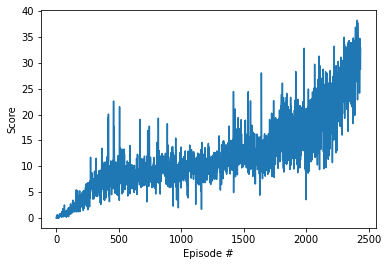

In [8]:
# graph for whole episode
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

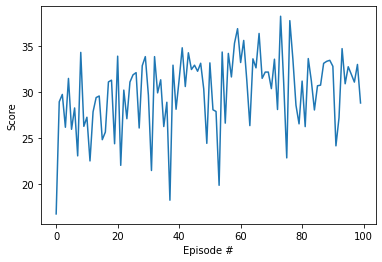

In [9]:
# last 100 episode score graph 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores[-100:])), scores[-100:])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Play Game With Trained Model

In [10]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor2.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic2.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations[0] 
scores = []
score = 0
for t in range(500):
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations[0]         # get next state (for each agent)
    rewards = env_info.rewards[0]                         # get reward (for each agent)
    dones = env_info.local_done[0]                       # see if episode finished
    states = next_states
    score += rewards 
    if dones:
        print('\r Average Score:{:.2f}'.format(np.mean(scores)))
        break 

In [11]:
print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
env.close()